In [2]:
## Libraries
suppressWarnings(suppressPackageStartupMessages({
  library(tidyverse)
  library(gganimate)
  library(janitor)
  library(cowplot)
  library(arrow)
  library(sportyR)
}))

In [2]:
## Data
post_throw <- arrow::read_parquet("data/post_throw_tracking.parquet")
pre_throw <- arrow::read_parquet("data/pre_throw_tracking.parquet")
supplement <- read_csv("data/supplementary_data.csv", show_col_types = FALSE)

## Getting team colors
team_colors <- suppressMessages(readr::read_tsv("https://raw.githubusercontent.com/asonty/ngs_highlights/master/utils/data/nfl_team_colors.tsv"))
team_colors <- rbind(team_colors, c("football","#935e38","black","#935e38"))

In [3]:
## Standardizing tracking data
pre_throw <- pre_throw |>
  mutate(
    x = ifelse(play_direction == "left", 120 - x, x),
    y = ifelse(play_direction == "left", 160 / 3 - y, y),
    dir = ifelse(play_direction == "left", dir + 180, dir),
    dir = ifelse(dir > 360, dir - 360, dir),
    o = ifelse(play_direction == "left", o + 180, o),
    o = ifelse(o > 360, o - 360, o)
  ) |> 
  left_join(supplement, by = c('game_id', 'play_id')) |>
  mutate(player_team = ifelse(player_side == "Offense", possession_team, defensive_team)) |>
  left_join(team_colors, by = c("player_team" = "teams"))

post_throw <- post_throw |>
  left_join(pre_throw |> select(game_id, play_id, nfl_id, play_direction, player_name, player_position, 
                                player_side, player_role, player_height, player_weight, player_team) |> distinct(), 
    by = c("game_id", "play_id", "nfl_id")
  ) |>
  mutate(
    x = ifelse(play_direction == "left", 120 - x, x),
    y = ifelse(play_direction == "left", 160 / 3 - y, y)
  ) |> 
  left_join(supplement, by = c('game_id', 'play_id')) |>
  left_join(team_colors, by = c("player_team" = "teams"))

In [4]:
# only pre-throw rows where `player_to_predict` == TRUE
pre_throw_true <- pre_throw |> filter(player_to_predict == TRUE)

In [5]:
## A couple EDA's
# 1a. 
summary(pre_throw$num_frames_output)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00    8.00   10.00   11.64   14.00   94.00 

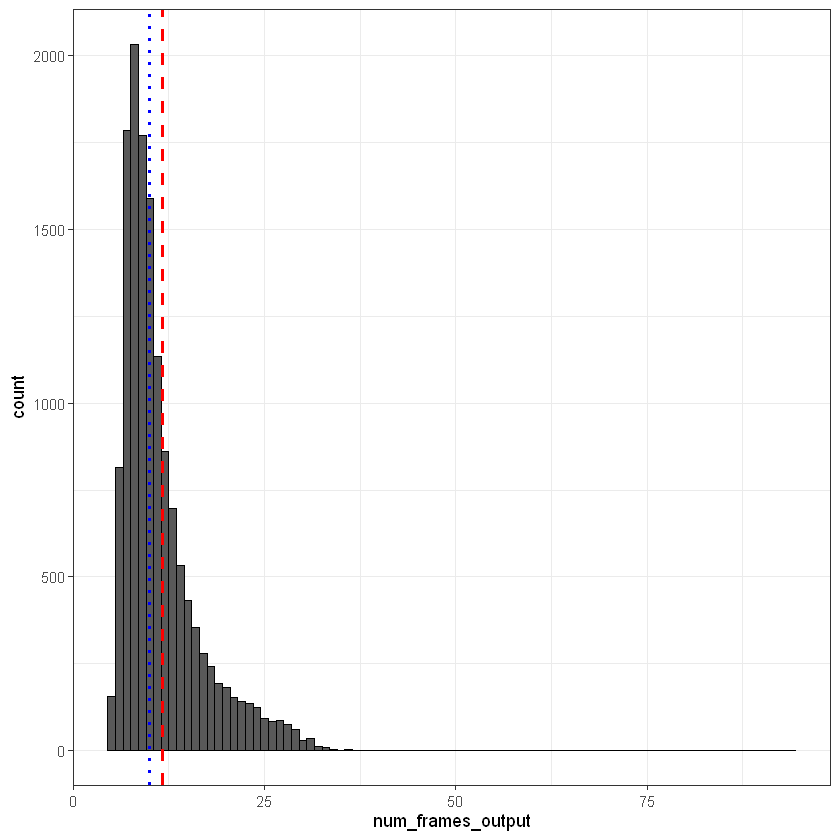

In [6]:
# 1b. Plotting histogram for frames of ball-in-air
pre_throw |> 
  group_by(game_id, play_id) |> 
  slice(1) |> 
  ggplot(aes(x = num_frames_output)) +
  geom_histogram(color = 'black', binwidth = 1) +
  geom_vline(xintercept = mean(pre_throw$num_frames_output), color = 'red', linetype = 'dashed', linewidth = 1) +
  geom_vline(xintercept = median(pre_throw$num_frames_output), color = 'blue', linetype = 'dotted', linewidth = 1) +
  theme_bw()

In [7]:
# 2. Coverage
table(pre_throw$team_coverage_type)
round(prop.table(table(pre_throw$team_coverage_type)), 2) # Idea: focus only on one coverage type, say COVER_3_ZONE??


 COVER_0_MAN  COVER_1_MAN  COVER_2_MAN COVER_2_ZONE COVER_3_ZONE COVER_4_ZONE 
      152518      1036462        85203       686183      1540309       841715 
COVER_6_ZONE      PREVENT 
      518919        18598 


 COVER_0_MAN  COVER_1_MAN  COVER_2_MAN COVER_2_ZONE COVER_3_ZONE COVER_4_ZONE 
        0.03         0.21         0.02         0.14         0.32         0.17 
COVER_6_ZONE      PREVENT 
        0.11         0.00 

In [8]:
# 3. Pass Result
table(pre_throw$pass_result)
round(prop.table(table(pre_throw$pass_result)), 2) # Idea: focus only on completed passes??


      C       I      IN 
3315905 1438412  126262 


   C    I   IN 
0.68 0.29 0.03 

In [9]:
# 4. In how many plays was the ball passed behind the LOS
n_plays_behind_LOS <- nrow(pre_throw_true |> group_by(game_id, play_id) |> slice(1) |> filter(pass_length < 0))
n_plays <- nrow(pre_throw_true |> group_by(game_id, play_id) |> slice(1))

pct_plays_behind_LOS <- round(n_plays_behind_LOS / n_plays * 100, 2)
print(pct_plays_behind_LOS) # Idea: remove plays where ball is thrown behind LOS (7.71% of unique game plays)??

[1] 7.71


In [ ]:
## General Ideas:

# A. Reaction time of defensive plays from initial position at time of throw to ball land x/y
# B. The target receiver's ability to "adjust" to a potentially under/over thrown pass
# C. Something relating to `route_of_targeted_receiver`
# D. Separation distance??
# E. ...
# F. ...

## Miscellaneous:

# Ravens (2024) led the NFL with 8.8 Yds/Pass Attempt, while the 49ers (2023) had 9.3, the highest that season.
# Eagles (2024) allowed the fewest with 6.0 Yds/Pass Attempt, while the Browns and Ravens (2023) tied at 5.9, lowest that year.

In [11]:
## Playing around with some animations

In [12]:
IRdisplay::display_html('<img src="play.gif">') # animation with pre_throw data containing raw tracking data

# YT link: https://youtu.be/J4DoMjut2aQ
# YT timestamp 0:32

In [13]:
IRdisplay::display_html('<img src="play_TRUE.gif">') # animation with pre_throw_true data containing only rows where `player_to_predict` == TRUE


## Discussion comment from Tom Bliss on the `player_to_predict` column
# The players to predict are the following:
# The Targeted receiver
# Defensive Players: - Within 5 yards of player at pass release OR - Able to reach land location of the ball, given a speed of 12 yds/second and the observed airtime of the pass
# These filters will sometimes include defensive players who do not cover the targeted receiver or go to the ball. When predicting a real play, it is important to include these players as they could cover the targeted receiver, even though they do not in the given case.